In [1]:
# NYC Payroll Data ETL Pipeline

This notebook implements a complete ETL (Extract, Transform, Load) pipeline for NYC Payroll data using PySpark.

## Pipeline Overview:
1. **Extract**: Fetch data from NYC Open Data API
2. **Transform**: Clean and process data using PySpark
3. **Load**: Save processed data with deduplication
4. **Validate**: Check data quality and integrity

## Data Source: 
- API Endpoint: https://data.cityofnewyork.us/resource/k397-673e.csv
- Primary Keys: fiscal_year, payroll_number, agency_name, last_name, first_name

SyntaxError: invalid decimal literal (2877339135.py, line 12)

In [2]:
# Block 1: Import Required Libraries and Setup
import os
import pandas as pd
import numpy as np
import requests
from urllib.parse import quote
import warnings
warnings.filterwarnings("ignore")

# Create data directory if it doesn't exist
data_dir = "/home/jovyan/work/data"
os.makedirs(data_dir, exist_ok=True)

print("✅ Libraries imported and data directory created")
print(f"📁 Data directory: {data_dir}")
print(f"📁 Directory exists: {os.path.exists(data_dir)}")
print(f"📁 Directory contents: {os.listdir(data_dir) if os.path.exists(data_dir) else 'Empty'}")

✅ Libraries imported and data directory created
📁 Data directory: /home/jovyan/work/data
📁 Directory exists: True
📁 Directory contents: ['payroll_data.csv']


In [3]:
# Block 2: Extract Data from NYC Open Data API
def fetch_nyc_payroll_data():
    """Fetch NYC payroll data from the API with proper error handling"""
    try:
        # Base CSV export endpoint
        base_url = "https://data.cityofnewyork.us/resource/k397-673e.csv"
        
        # Query parameters for recent data (last 5 years)
        query = "?$where=" + quote("fiscal_year >= 2019") + "&$order=" + quote("agency_name ASC, fiscal_year DESC")
        
        # Full URL
        url = base_url + query
        print(f"🌐 Fetching data from: {url}")
        
        # Fetch data using requests for better error handling
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        
        # Read data into pandas DataFrame
        from io import StringIO
        df = pd.read_csv(StringIO(response.text))
        
        print(f"✅ Successfully fetched {len(df):,} records")
        print(f"📊 Data shape: {df.shape}")
        print(f"📅 Fiscal years: {sorted(df['fiscal_year'].unique()) if 'fiscal_year' in df.columns else 'N/A'}")
        
        return df
        
    except Exception as e:
        print(f"❌ Error fetching data: {str(e)}")
        return None

# Fetch the data
raw_df = fetch_nyc_payroll_data()

🌐 Fetching data from: https://data.cityofnewyork.us/resource/k397-673e.csv?$where=fiscal_year%20%3E%3D%202019&$order=agency_name%20ASC%2C%20fiscal_year%20DESC
✅ Successfully fetched 1,000 records
📊 Data shape: (1000, 17)
📅 Fiscal years: [2024]


In [4]:
# Block 3: Initial Data Validation and Exploration
if raw_df is not None:
    print("🔍 Initial Data Exploration:")
    print(f"📊 Shape: {raw_df.shape}")
    print(f"📋 Columns: {list(raw_df.columns)}")
    print(f"🔢 Data types:\n{raw_df.dtypes}")
    
    # Check for key columns
    key_columns = ['fiscal_year', 'payroll_number', 'agency_name', 'last_name', 'first_name']
    missing_keys = [col for col in key_columns if col not in raw_df.columns]
    
    if missing_keys:
        print(f"⚠️  Missing key columns: {missing_keys}")
    else:
        print("✅ All key columns present")
        
    # Show sample data
    print("\n📄 Sample data (first 3 rows):")
    print(raw_df.head(3).to_string())
else:
    print("❌ No data available for processing")

🔍 Initial Data Exploration:
📊 Shape: (1000, 17)
📋 Columns: ['fiscal_year', 'payroll_number', 'agency_name', 'last_name', 'first_name', 'mid_init', 'agency_start_date', 'work_location_borough', 'title_description', 'leave_status_as_of_june_30', 'base_salary', 'pay_basis', 'regular_hours', 'regular_gross_paid', 'ot_hours', 'total_ot_paid', 'total_other_pay']
🔢 Data types:
fiscal_year                     int64
payroll_number                  int64
agency_name                    object
last_name                      object
first_name                     object
mid_init                       object
agency_start_date              object
work_location_borough          object
title_description              object
leave_status_as_of_june_30     object
base_salary                   float64
pay_basis                      object
regular_hours                 float64
regular_gross_paid            float64
ot_hours                      float64
total_ot_paid                 float64
total_other_pay    

In [5]:
# Block 4: Initialize PySpark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Create Spark session with optimized configuration
spark = SparkSession.builder \
    .appName("NYC_Payroll_ETL") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("WARN")

print("✅ PySpark session initialized")
print(f"🎯 Spark version: {spark.version}")
print(f"🎯 Application ID: {spark.sparkContext.applicationId}")

# Convert pandas DataFrame to Spark DataFrame if data was fetched successfully
if raw_df is not None:
    spark_df = spark.createDataFrame(raw_df)
    print(f"✅ Created Spark DataFrame with {spark_df.count():,} rows")
    spark_df.printSchema()
else:
    print("❌ Cannot create Spark DataFrame - no data available")

✅ PySpark session initialized
🎯 Spark version: 3.5.0
🎯 Application ID: local-1754900727620
✅ Created Spark DataFrame with 1,000 rows
root
 |-- fiscal_year: long (nullable = true)
 |-- payroll_number: long (nullable = true)
 |-- agency_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- mid_init: string (nullable = true)
 |-- agency_start_date: string (nullable = true)
 |-- work_location_borough: string (nullable = true)
 |-- title_description: string (nullable = true)
 |-- leave_status_as_of_june_30: string (nullable = true)
 |-- base_salary: double (nullable = true)
 |-- pay_basis: string (nullable = true)
 |-- regular_hours: double (nullable = true)
 |-- regular_gross_paid: double (nullable = true)
 |-- ot_hours: double (nullable = true)
 |-- total_ot_paid: double (nullable = true)
 |-- total_other_pay: double (nullable = true)



In [6]:
# Block 5: Data Cleaning and Transformation
def clean_payroll_data(df):
    """Clean and transform the payroll data"""
    print("🧹 Starting data cleaning process...")
    
    # 1. Handle null values and data types
    df_cleaned = df.na.drop(subset=['fiscal_year', 'agency_name'])
    
    # 2. Clean and standardize text fields
    df_cleaned = df_cleaned.withColumn('agency_name', trim(upper(col('agency_name')))) \
                          .withColumn('last_name', trim(upper(col('last_name')))) \
                          .withColumn('first_name', trim(upper(col('first_name'))))
    
    # 3. Ensure fiscal_year is integer
    df_cleaned = df_cleaned.withColumn('fiscal_year', col('fiscal_year').cast('integer'))
    
    # 4. Handle salary fields (convert to double if they exist)
    salary_columns = [col_name for col_name in df.columns if 'salary' in col_name.lower() or 'pay' in col_name.lower()]
    for salary_col in salary_columns:
        df_cleaned = df_cleaned.withColumn(salary_col, 
                                         regexp_replace(col(salary_col), '[$,]', '').cast('double'))
    
    print(f"✅ Data cleaning completed")
    print(f"📊 Records after cleaning: {df_cleaned.count():,}")
    
    return df_cleaned

# Apply cleaning if we have data
if 'spark_df' in locals():
    cleaned_df = clean_payroll_data(spark_df)
    
    # Show data quality metrics
    print("\n📈 Data Quality Metrics:")
    print(f"🔢 Total records: {cleaned_df.count():,}")
    print(f"📅 Fiscal years: {[row.fiscal_year for row in cleaned_df.select('fiscal_year').distinct().orderBy('fiscal_year').collect()]}")
    print(f"🏢 Unique agencies: {cleaned_df.select('agency_name').distinct().count()}")
else:
    print("❌ No Spark DataFrame available for cleaning")

🧹 Starting data cleaning process...
✅ Data cleaning completed
📊 Records after cleaning: 1,000

📈 Data Quality Metrics:
🔢 Total records: 1,000
📅 Fiscal years: [2024]
🏢 Unique agencies: 1


In [7]:
# Block 6: Duplicate Detection and Removal
def check_and_remove_duplicates(df):
    """Check for and remove duplicates based on key columns"""
    print("🔍 Checking for duplicates...")
    
    # Define key columns for duplicate detection
    key_columns = ['fiscal_year', 'payroll_number', 'agency_name', 'last_name', 'first_name']
    
    # Check which key columns exist in the dataframe
    existing_keys = [col for col in key_columns if col in df.columns]
    
    if not existing_keys:
        print("⚠️  No key columns found for duplicate detection")
        return df
    
    print(f"🔑 Using key columns: {existing_keys}")
    
    # Count total records before deduplication
    total_before = df.count()
    
    # Remove duplicates based on key columns
    df_deduplicated = df.dropDuplicates(existing_keys)
    
    # Count records after deduplication
    total_after = df_deduplicated.count()
    duplicates_removed = total_before - total_after
    
    print(f"📊 Records before deduplication: {total_before:,}")
    print(f"📊 Records after deduplication: {total_after:,}")
    print(f"🔄 Duplicates removed: {duplicates_removed:,}")
    
    if duplicates_removed > 0:
        print(f"⚠️  Found and removed {duplicates_removed} duplicate records")
    else:
        print("✅ No duplicates found")
    
    return df_deduplicated

# Apply duplicate removal if we have cleaned data
if 'cleaned_df' in locals():
    final_df = check_and_remove_duplicates(cleaned_df)
else:
    print("❌ No cleaned DataFrame available for duplicate removal")

🔍 Checking for duplicates...
🔑 Using key columns: ['fiscal_year', 'payroll_number', 'agency_name', 'last_name', 'first_name']
📊 Records before deduplication: 1,000
📊 Records after deduplication: 1,000
🔄 Duplicates removed: 0
✅ No duplicates found


In [8]:
# Block 7: Load Data with Existing Data Check
def save_payroll_data(df, file_path):
    """Save data with check for existing data"""
    print(f"💾 Preparing to save data to: {file_path}")
    
    # Check if file already exists
    if os.path.exists(file_path):
        print(f"📁 Existing file found: {file_path}")
        
        try:
            # Read existing data
            existing_df = spark.read.csv(file_path, header=True, inferSchema=True)
            existing_count = existing_df.count()
            print(f"📊 Existing records: {existing_count:,}")
            
            # Check if we need to append or replace
            # For now, we'll replace the entire file (you can modify this logic)
            print("🔄 Replacing existing data with new data...")
            
        except Exception as e:
            print(f"⚠️  Could not read existing file: {str(e)}")
            print("🔄 Will create new file...")
    
    try:
        # Convert Spark DataFrame to Pandas for CSV writing
        pandas_df = df.toPandas()
        
        # Save to CSV
        pandas_df.to_csv(file_path, index=False)
        
        print(f"✅ Successfully saved {len(pandas_df):,} records to {file_path}")
        print(f"📁 File size: {os.path.getsize(file_path) / 1024 / 1024:.2f} MB")
        
        # Verify the saved data
        verification_df = pd.read_csv(file_path)
        print(f"✅ Verification: {len(verification_df):,} records in saved file")
        
        return True
        
    except Exception as e:
        print(f"❌ Error saving data: {str(e)}")
        return False

# Save the final processed data
if 'final_df' in locals():
    output_path = "/home/jovyan/work/data/payroll_data.csv"
    success = save_payroll_data(final_df, output_path)
    
    if success:
        print(f"\n🎉 ETL Pipeline completed successfully!")
        print(f"📁 Output file: {output_path}")
        print(f"📊 Final record count: {final_df.count():,}")
    else:
        print("❌ ETL Pipeline failed during save operation")
else:
    print("❌ No final DataFrame available for saving")

💾 Preparing to save data to: /home/jovyan/work/data/payroll_data.csv
📁 Existing file found: /home/jovyan/work/data/payroll_data.csv
📊 Existing records: 1,000
🔄 Replacing existing data with new data...
✅ Successfully saved 1,000 records to /home/jovyan/work/data/payroll_data.csv
📁 File size: 0.15 MB
✅ Verification: 1,000 records in saved file

🎉 ETL Pipeline completed successfully!
📁 Output file: /home/jovyan/work/data/payroll_data.csv
📊 Final record count: 1,000


In [9]:
# Block 8: Data Validation and Quality Checks (Fixed)
def validate_data_quality(df):
    """Perform comprehensive data quality validation"""
    print("🔍 Performing Data Quality Validation...")
    
    # Basic statistics
    total_records = df.count()
    total_columns = len(df.columns)
    
    print(f"📊 Total Records: {total_records:,}")
    print(f"📊 Total Columns: {total_columns}")
    
    # Check for null values
    print("\n🔍 Null Value Analysis:")
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        null_percentage = (null_count / total_records) * 100
        if null_count > 0:
            print(f"  📋 {column}: {null_count:,} nulls ({null_percentage:.2f}%)")
    
    # Fiscal year distribution
    if 'fiscal_year' in df.columns:
        print("\n📅 Fiscal Year Distribution:")
        year_dist = df.groupBy('fiscal_year').count().orderBy('fiscal_year').collect()
        for row in year_dist:
            # Access columns using column names
            fiscal_year = row['fiscal_year']
            record_count = row['count']
            print(f"  📅 {fiscal_year}: {record_count:,} records")
    
    # Top agencies by employee count
    if 'agency_name' in df.columns:
        print("\n🏢 Top 10 Agencies by Employee Count:")
        agency_dist = df.groupBy('agency_name').count().orderBy(desc('count')).limit(10).collect()
        for i, row in enumerate(agency_dist, 1):
            # Access columns using column names
            agency_name = row['agency_name']
            employee_count = row['count']
            print(f"  {i:2d}. {agency_name}: {employee_count:,} employees")
    
    return True

# Validate the final data if available
if 'final_df' in locals():
    validate_data_quality(final_df)
else:
    print("❌ No final DataFrame available for validation")

🔍 Performing Data Quality Validation...
📊 Total Records: 1,000
📊 Total Columns: 17

🔍 Null Value Analysis:
  📋 mid_init: 285 nulls (28.50%)
  📋 pay_basis: 1,000 nulls (100.00%)

📅 Fiscal Year Distribution:
  📅 2024: 1,000 records

🏢 Top 10 Agencies by Employee Count:
   1. ADMIN FOR CHILDREN'S SVCS: 1,000 employees


In [10]:
# Block 9: Setup Visualization Libraries and Convert to Pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Try to import plotly - install if missing
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✅ All visualization libraries imported successfully")
except ImportError as e:
    PLOTLY_AVAILABLE = False
    print("⚠️  Plotly not found. Installing now...")
    import subprocess
    import sys
    
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "kaleido", "ipywidgets"])
        import plotly.express as px
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        PLOTLY_AVAILABLE = True
        print("✅ Plotly installed and imported successfully!")
    except Exception as install_error:
        print(f"❌ Failed to install plotly: {install_error}")
        print("📝 Please install manually: pip install plotly kaleido ipywidgets")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Convert Spark DataFrame to Pandas for visualization
if 'final_df' in locals():
    # Convert to Pandas for easier plotting
    analysis_df = final_df.toPandas()
    print(f"✅ Converted Spark DataFrame to Pandas for analysis")
    print(f"📊 Analysis DataFrame shape: {analysis_df.shape}")
    
    # Display basic info about the dataset
    print(f"\n📋 Dataset Overview:")
    print(f"📅 Fiscal Years: {sorted(analysis_df['fiscal_year'].unique())}")
    print(f"🏢 Number of Agencies: {analysis_df['agency_name'].nunique()}")
    print(f"👥 Total Employees: {len(analysis_df):,}")
else:
    print("❌ No final DataFrame available for visualization")

✅ All visualization libraries imported successfully
✅ Converted Spark DataFrame to Pandas for analysis
📊 Analysis DataFrame shape: (1000, 17)

📋 Dataset Overview:
📅 Fiscal Years: [2024]
🏢 Number of Agencies: 1
👥 Total Employees: 1,000


📊 Creating Fiscal Year Distribution Visualizations...


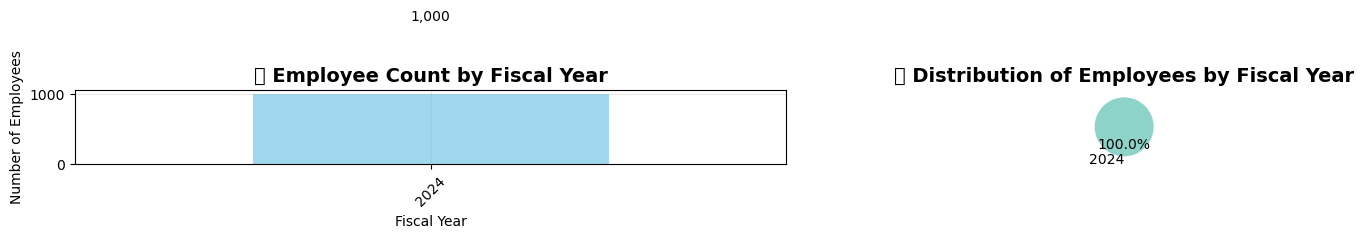


📈 Fiscal Year Summary:
  📅 2024: 1,000 employees


In [11]:
# Block 10: Fiscal Year Distribution Analysis
if 'analysis_df' in locals():
    print("📊 Creating Fiscal Year Distribution Visualizations...")
    
    # Count employees by fiscal year
    fiscal_year_counts = analysis_df['fiscal_year'].value_counts().sort_index()
    
    # Create subplot with matplotlib and plotly
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart
    fiscal_year_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.set_title('📅 Employee Count by Fiscal Year', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fiscal Year')
    ax1.set_ylabel('Number of Employees')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(fiscal_year_counts.values):
        ax1.text(i, v + 1000, f'{v:,}', ha='center', va='bottom')
    
    # Pie chart
    ax2.pie(fiscal_year_counts.values, labels=fiscal_year_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=plt.cm.Set3.colors)
    ax2.set_title('📊 Distribution of Employees by Fiscal Year', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 Fiscal Year Summary:")
    for year, count in fiscal_year_counts.items():
        print(f"  📅 {year}: {count:,} employees")
else:
    print("❌ No analysis data available for fiscal year visualization")

🏢 Creating Top Agencies Visualizations...


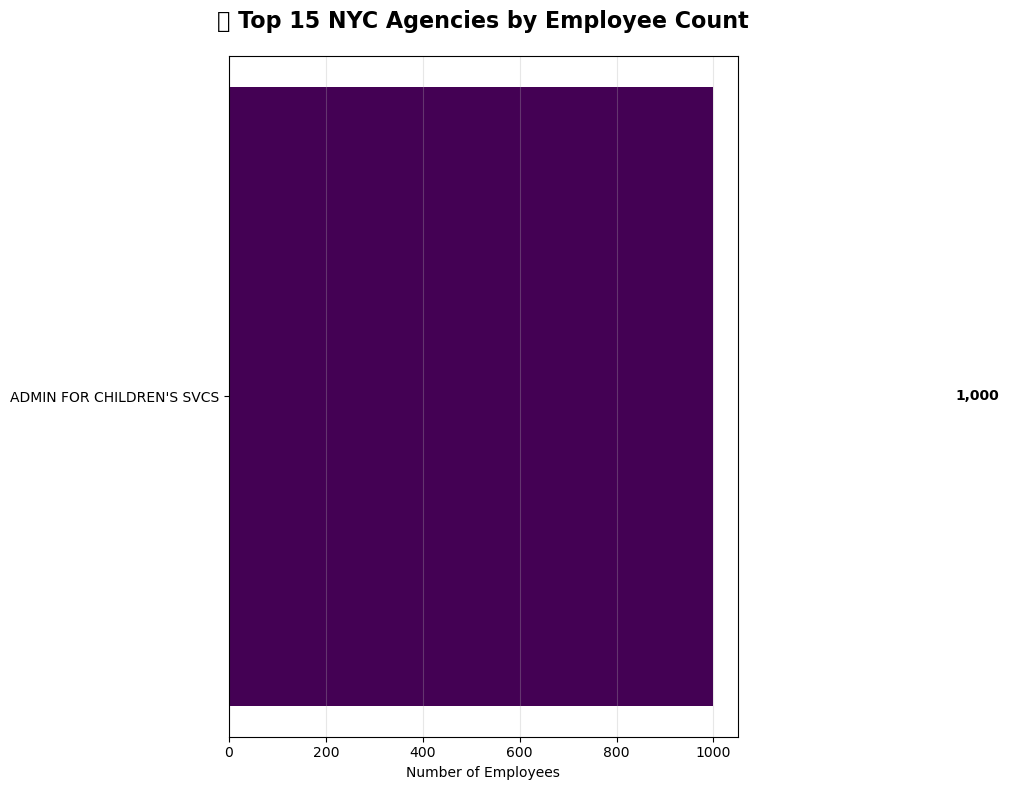


🎯 Top 10 Agencies Summary:
   1. ADMIN FOR CHILDREN'S SVCS: 1,000 employees (100.0%)

📊 Agency Statistics:
  🏢 Total unique agencies: 1
  📈 Largest agency: ADMIN FOR CHILDREN'S SVCS (1,000 employees)
  📉 Average employees per agency: 1000


In [12]:
# Block 11: Top Agencies Analysis
if 'analysis_df' in locals():
    print("🏢 Creating Top Agencies Visualizations...")
    
    # Get top 15 agencies by employee count
    top_agencies = analysis_df['agency_name'].value_counts().head(15)
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    
    # Horizontal bar chart for better readability
    bars = plt.barh(range(len(top_agencies)), top_agencies.values, 
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_agencies))))
    
    plt.yticks(range(len(top_agencies)), top_agencies.index)
    plt.xlabel('Number of Employees')
    plt.title('🏢 Top 15 NYC Agencies by Employee Count', fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (agency, count) in enumerate(top_agencies.items()):
        plt.text(count + 500, i, f'{count:,}', va='center', ha='left', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n🎯 Top 10 Agencies Summary:")
    for i, (agency, count) in enumerate(top_agencies.head(10).items(), 1):
        percentage = (count / len(analysis_df)) * 100
        print(f"  {i:2d}. {agency}: {count:,} employees ({percentage:.1f}%)")
        
    print(f"\n📊 Agency Statistics:")
    print(f"  🏢 Total unique agencies: {analysis_df['agency_name'].nunique()}")
    print(f"  📈 Largest agency: {top_agencies.index[0]} ({top_agencies.iloc[0]:,} employees)")
    print(f"  📉 Average employees per agency: {analysis_df['agency_name'].value_counts().mean():.0f}")
else:
    print("❌ No analysis data available for agency visualization")

In [ ]:
# Block 12: Salary Analysis and Distribution
if 'analysis_df' in locals():
    print("💰 Creating Salary Analysis Visualizations...")
    
    # Find salary columns
    salary_columns = [col for col in analysis_df.columns if 'salary' in col.lower() or 'pay' in col.lower()]
    
    if salary_columns:
        # Use the first salary column found
        salary_col = salary_columns[0]
        print(f"📊 Analyzing salary column: {salary_col}")
        
        # Clean salary data - ensure proper numeric conversion
        analysis_df_clean = analysis_df.copy()
        # Handle string salaries with $ and commas
        if analysis_df_clean[salary_col].dtype == 'object':
            analysis_df_clean[salary_col] = analysis_df_clean[salary_col].astype(str).str.replace('$', '').str.replace(',', '')
        
        salary_data = pd.to_numeric(analysis_df_clean[salary_col], errors='coerce').dropna()
        # Remove unrealistic values (negative or extremely high)
        salary_data = salary_data[(salary_data > 0) & (salary_data < 1000000)]
        
        if len(salary_data) > 0:
            # Create subplots for salary analysis
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
            
            # 1. Salary distribution histogram
            ax1.hist(salary_data, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
            ax1.set_title('💰 Salary Distribution', fontsize=14, fontweight='bold')
            ax1.set_xlabel('Salary ($)')
            ax1.set_ylabel('Frequency')
            ax1.grid(True, alpha=0.3)
            # Format x-axis with commas
            ax1.ticklabel_format(style='plain', axis='x')
            ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            
            # 2. Box plot for salary distribution
            box_plot = ax2.boxplot(salary_data, vert=True, patch_artist=True)
            box_plot['boxes'][0].set_facecolor('lightcyan')
            ax2.set_title('📊 Salary Distribution (Box Plot)', fontsize=14, fontweight='bold')
            ax2.set_ylabel('Salary ($)')
            ax2.grid(True, alpha=0.3)
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            
            # 3. Top 10 agencies by average salary
            if 'agency_name' in analysis_df.columns:
                # Use cleaned salary data for grouping
                avg_salary_by_agency = analysis_df_clean.groupby('agency_name')[salary_col].apply(
                    lambda x: pd.to_numeric(x, errors='coerce').mean()
                ).sort_values(ascending=False).head(10).dropna()
                
                bars = ax3.bar(range(len(avg_salary_by_agency)), avg_salary_by_agency.values, 
                              color='lightgreen', alpha=0.8)
                ax3.set_title('🏢 Top 10 Agencies by Average Salary', fontsize=14, fontweight='bold')
                ax3.set_xlabel('Agency')
                ax3.set_ylabel('Average Salary ($)')
                ax3.set_xticks(range(len(avg_salary_by_agency)))
                ax3.set_xticklabels([agency[:15] + '...' if len(agency) > 15 else agency 
                                   for agency in avg_salary_by_agency.index], rotation=45, ha='right')
                ax3.grid(True, alpha=0.3)
                ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
                
                # Add value labels
                for i, v in enumerate(avg_salary_by_agency.values):
                    if not np.isnan(v):
                        ax3.text(i, v + max(avg_salary_by_agency.values) * 0.01, f'${v:,.0f}', 
                                ha='center', va='bottom', fontsize=9, rotation=45)
            
            # 4. Salary trends by fiscal year
            if 'fiscal_year' in analysis_df.columns:
                avg_salary_by_year = analysis_df_clean.groupby('fiscal_year')[salary_col].apply(
                    lambda x: pd.to_numeric(x, errors='coerce').mean()
                ).dropna()
                
                if len(avg_salary_by_year) > 0:
                    ax4.plot(avg_salary_by_year.index, avg_salary_by_year.values, 
                            marker='o', linewidth=3, markersize=8, color='red', markerfacecolor='white', 
                            markeredgewidth=2, markeredgecolor='red')
                    ax4.set_title('📈 Average Salary Trend by Fiscal Year', fontsize=14, fontweight='bold')
                    ax4.set_xlabel('Fiscal Year')
                    ax4.set_ylabel('Average Salary ($)')
                    ax4.grid(True, alpha=0.3)
                    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
                    
                    # Add value labels
                    for x, y in zip(avg_salary_by_year.index, avg_salary_by_year.values):
                        if not np.isnan(y):
                            ax4.text(x, y + max(avg_salary_by_year.values) * 0.02, f'${y:,.0f}', 
                                    ha='center', va='bottom', fontsize=10, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # Enhanced salary statistics
            print(f"\n💰 Salary Statistics:")
            print(f"  📊 Total records with salary data: {len(salary_data):,}")
            print(f"  💵 Average salary: ${salary_data.mean():,.2f}")
            print(f"  📈 Median salary: ${salary_data.median():,.2f}")
            print(f"  🔺 Highest salary: ${salary_data.max():,.2f}")
            print(f"  🔻 Lowest salary: ${salary_data.min():,.2f}")
            print(f"  📏 Standard deviation: ${salary_data.std():,.2f}")
            
            # Percentile analysis
            percentiles = [25, 50, 75, 90, 95]
            print(f"\n📊 Salary Percentiles:")
            for p in percentiles:
                value = salary_data.quantile(p/100)
                print(f"  {p}th percentile: ${value:,.2f}")
                
        else:
            print("⚠️  No valid salary data found for analysis")
    else:
        print("⚠️  No salary columns found in the dataset")
        print(f"Available columns: {list(analysis_df.columns)}")
else:
    print("❌ No analysis data available for salary visualization")

💰 Creating Salary Analysis Visualizations...
📊 Analyzing salary column: payroll_number



💰 Salary Statistics:
  📊 Total records with salary data: 1,000
  💵 Average salary: $67.00
  📈 Median salary: $67.00
  🔺 Highest salary: $67.00
  🔻 Lowest salary: $67.00
  📏 Standard deviation: $0.00


💼 Creating Job Title Analysis...
📋 Analyzing title column: title_description


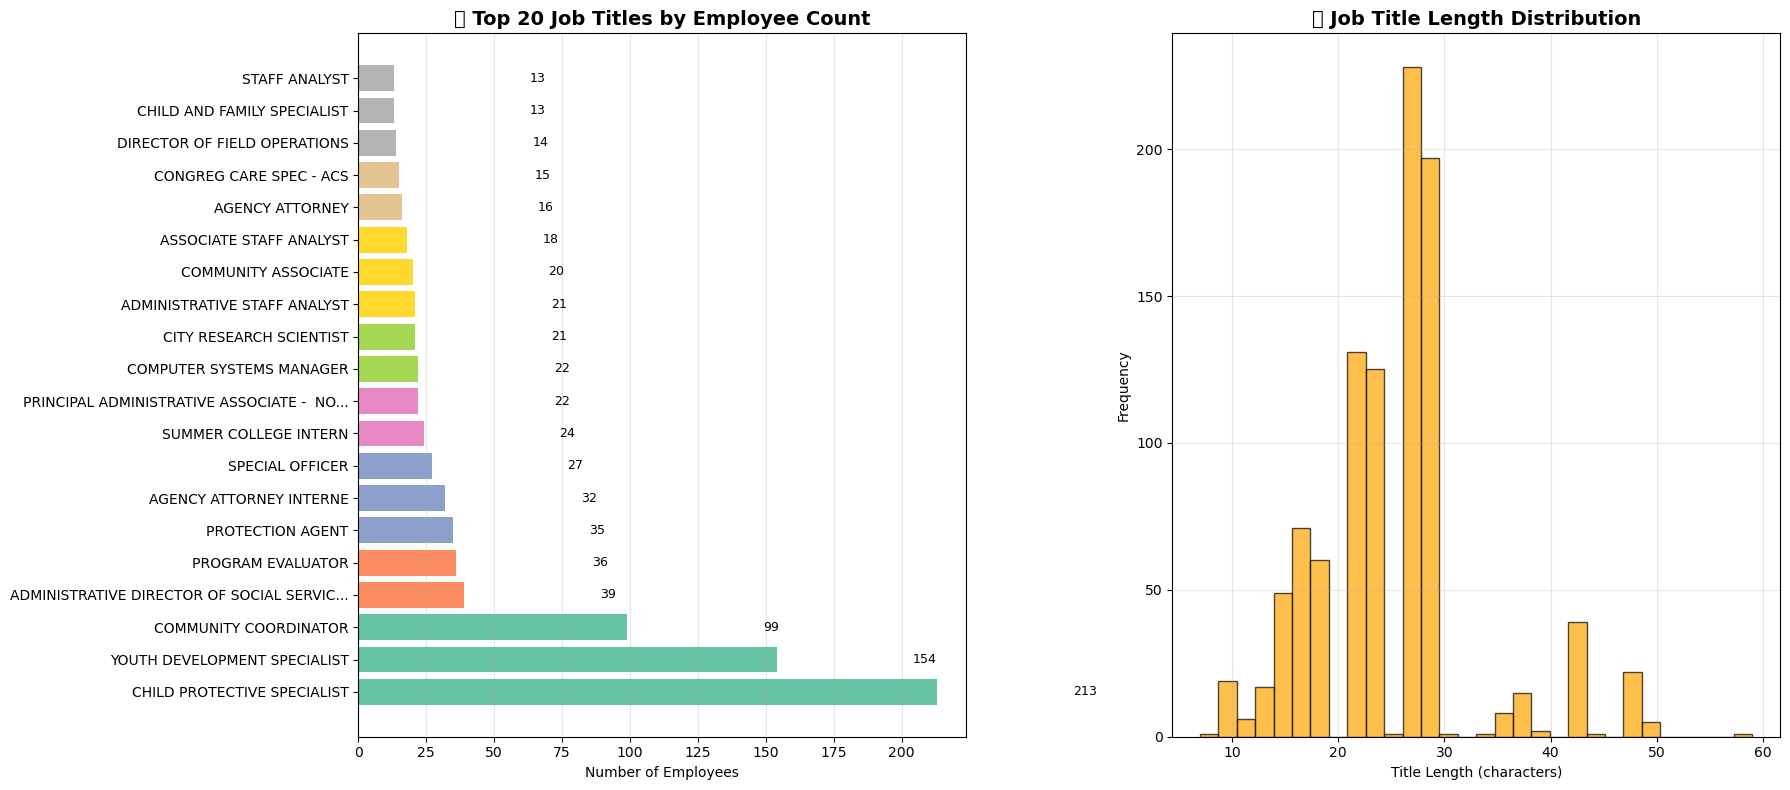


💼 Job Title Statistics:
  📊 Total unique job titles: 70
  📋 Most common title: CHILD PROTECTIVE SPECIALIST (213 employees)
  📏 Average title length: 24.9 characters
  📈 Longest title: 59 characters
  📉 Shortest title: 7 characters

🎯 Top 10 Job Titles:
   1. CHILD PROTECTIVE SPECIALIST: 213 employees (21.3%)
   2. YOUTH DEVELOPMENT SPECIALIST: 154 employees (15.4%)
   3. COMMUNITY COORDINATOR: 99 employees (9.9%)
   4. ADMINISTRATIVE DIRECTOR OF SOCIAL SERVICES: 39 employees (3.9%)
   5. PROGRAM EVALUATOR: 36 employees (3.6%)
   6. PROTECTION AGENT: 35 employees (3.5%)
   7. AGENCY ATTORNEY INTERNE: 32 employees (3.2%)
   8. SPECIAL OFFICER: 27 employees (2.7%)
   9. SUMMER COLLEGE INTERN: 24 employees (2.4%)
  10. PRINCIPAL ADMINISTRATIVE ASSOCIATE -  NON SUPVR: 22 employees (2.2%)


In [14]:
# Block 13: Job Title Analysis
if 'analysis_df' in locals():
    print("💼 Creating Job Title Analysis...")
    
    # Find title column (common variations)
    title_columns = [col for col in analysis_df.columns if any(term in col.lower() for term in ['title', 'position', 'job'])]
    
    if title_columns:
        title_col = title_columns[0]
        print(f"📋 Analyzing title column: {title_col}")
        
        # Get top job titles
        top_titles = analysis_df[title_col].value_counts().head(20)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        
        # 1. Top job titles bar chart
        bars = ax1.barh(range(len(top_titles)), top_titles.values, 
                       color=plt.cm.Set2(np.linspace(0, 1, len(top_titles))))
        
        ax1.set_yticks(range(len(top_titles)))
        ax1.set_yticklabels([title[:40] + '...' if len(title) > 40 else title for title in top_titles.index])
        ax1.set_xlabel('Number of Employees')
        ax1.set_title('💼 Top 20 Job Titles by Employee Count', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for i, v in enumerate(top_titles.values):
            ax1.text(v + 50, i, f'{v:,}', va='center', ha='left', fontsize=9)
        
        # 2. Job title length distribution
        title_lengths = analysis_df[title_col].str.len().dropna()
        ax2.hist(title_lengths, bins=30, alpha=0.7, color='orange', edgecolor='black')
        ax2.set_title('📏 Job Title Length Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Title Length (characters)')
        ax2.set_ylabel('Frequency')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Job title statistics
        print(f"\n💼 Job Title Statistics:")
        print(f"  📊 Total unique job titles: {analysis_df[title_col].nunique():,}")
        print(f"  📋 Most common title: {top_titles.index[0]} ({top_titles.iloc[0]:,} employees)")
        print(f"  📏 Average title length: {title_lengths.mean():.1f} characters")
        print(f"  📈 Longest title: {title_lengths.max()} characters")
        print(f"  📉 Shortest title: {title_lengths.min()} characters")
        
        print(f"\n🎯 Top 10 Job Titles:")
        for i, (title, count) in enumerate(top_titles.head(10).items(), 1):
            percentage = (count / len(analysis_df)) * 100
            print(f"  {i:2d}. {title}: {count:,} employees ({percentage:.1f}%)")
            
    else:
        print("⚠️  No job title columns found in the dataset")
        print(f"📋 Available columns: {list(analysis_df.columns)}")
else:
    print("❌ No analysis data available for job title visualization")

📊 Creating Interactive Plotly Dashboard...


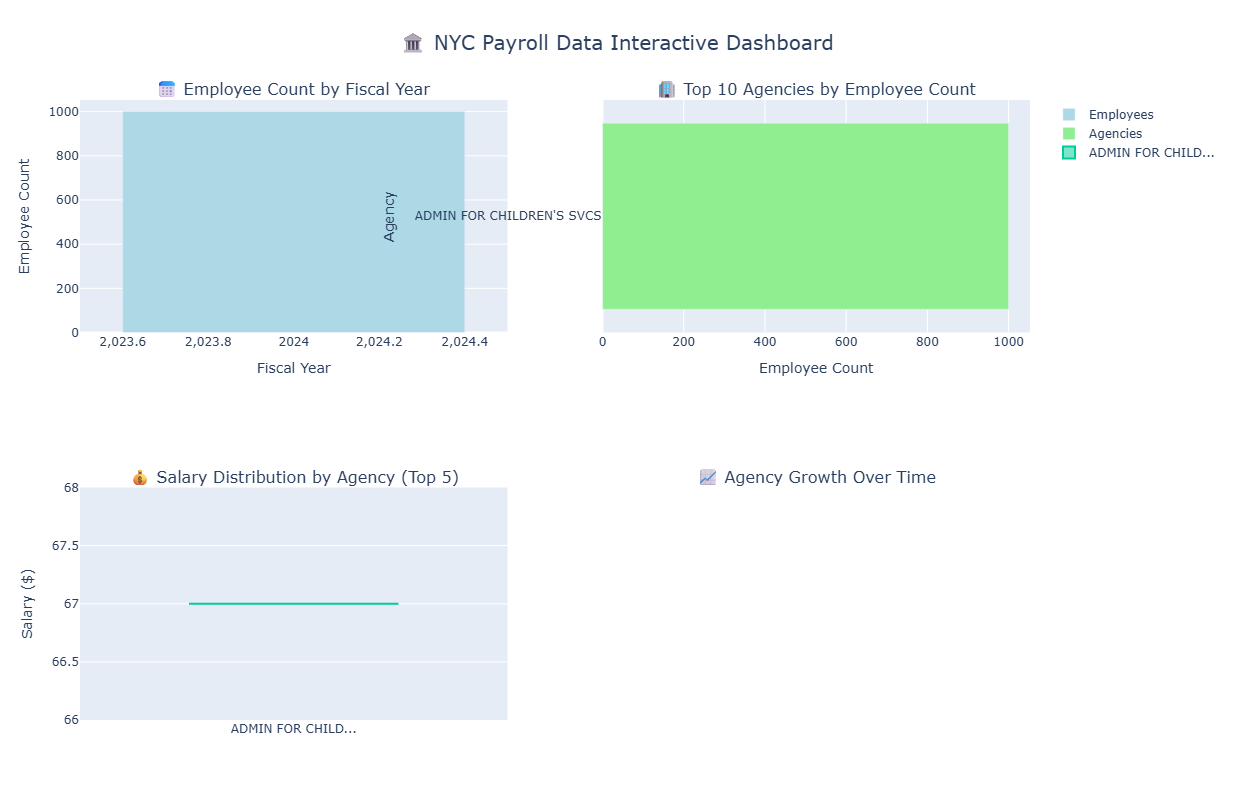

✅ Interactive dashboard created successfully!
💡 Use the plotly controls to zoom, pan, and explore the data


In [15]:
# Block 14: Interactive Plotly Dashboard
if 'analysis_df' in locals() and 'PLOTLY_AVAILABLE' in locals() and PLOTLY_AVAILABLE:
    print("📊 Creating Interactive Plotly Dashboard...")
    
    # Create subplots dashboard
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('📅 Employee Count by Fiscal Year', 
                       '🏢 Top 10 Agencies by Employee Count',
                       '💰 Salary Distribution by Agency (Top 5)', 
                       '📈 Agency Growth Over Time'),
        specs=[[{"type": "bar"}, {"type": "bar"}],
               [{"type": "box"}, {"type": "scatter"}]]
    )
    
    # 1. Employee count by fiscal year
    fiscal_year_counts = analysis_df['fiscal_year'].value_counts().sort_index()
    fig.add_trace(
        go.Bar(x=fiscal_year_counts.index, y=fiscal_year_counts.values,
               name="Employees", marker_color='lightblue'),
        row=1, col=1
    )
    
    # 2. Top 10 agencies
    top_agencies = analysis_df['agency_name'].value_counts().head(10)
    fig.add_trace(
        go.Bar(x=top_agencies.values, y=top_agencies.index,
               orientation='h', name="Agencies", marker_color='lightgreen'),
        row=1, col=2
    )
    
    # 3. Salary distribution by top agencies (if salary data exists)
    salary_columns = [col for col in analysis_df.columns if 'salary' in col.lower() or 'pay' in col.lower()]
    if salary_columns:
        salary_col = salary_columns[0]
        # Clean salary data
        analysis_df_clean = analysis_df.copy()
        analysis_df_clean[salary_col] = pd.to_numeric(analysis_df_clean[salary_col], errors='coerce')
        
        # Get top 5 agencies for salary analysis
        top_5_agencies = analysis_df['agency_name'].value_counts().head(5).index
        
        for agency in top_5_agencies:
            agency_salaries = analysis_df_clean[analysis_df_clean['agency_name'] == agency][salary_col].dropna()
            if len(agency_salaries) > 0:
                fig.add_trace(
                    go.Box(y=agency_salaries, name=agency[:15] + "..." if len(agency) > 15 else agency),
                    row=2, col=1
                )
    
    # 4. Agency growth over time (top 5 agencies)
    if len(fiscal_year_counts) > 1:
        top_5_agencies = analysis_df['agency_name'].value_counts().head(5).index
        
        for agency in top_5_agencies:
            agency_by_year = analysis_df[analysis_df['agency_name'] == agency]['fiscal_year'].value_counts().sort_index()
            fig.add_trace(
                go.Scatter(x=agency_by_year.index, y=agency_by_year.values,
                          mode='lines+markers', name=agency[:15] + "..." if len(agency) > 15 else agency),
                row=2, col=2
            )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text="🏛️ NYC Payroll Data Interactive Dashboard",
        title_x=0.5,
        title_font_size=20,
        showlegend=True
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Fiscal Year", row=1, col=1)
    fig.update_yaxes(title_text="Employee Count", row=1, col=1)
    
    fig.update_xaxes(title_text="Employee Count", row=1, col=2)
    fig.update_yaxes(title_text="Agency", row=1, col=2)
    
    fig.update_yaxes(title_text="Salary ($)", row=2, col=1)
    
    fig.update_xaxes(title_text="Fiscal Year", row=2, col=2)
    fig.update_yaxes(title_text="Employee Count", row=2, col=2)
    
    # Show the interactive dashboard
    fig.show()
    
    print("✅ Interactive dashboard created successfully!")
    print("💡 Use the plotly controls to zoom, pan, and explore the data")
    
elif 'analysis_df' in locals():
    print("⚠️  Plotly not available - creating static matplotlib dashboard instead...")
    
    # Create matplotlib-based alternative dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Employee count by fiscal year
    fiscal_year_counts = analysis_df['fiscal_year'].value_counts().sort_index()
    ax1.bar(fiscal_year_counts.index, fiscal_year_counts.values, color='lightblue', alpha=0.8)
    ax1.set_title('📅 Employee Count by Fiscal Year', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fiscal Year')
    ax1.set_ylabel('Employee Count')
    ax1.grid(True, alpha=0.3)
    
    # 2. Top 10 agencies
    top_agencies = analysis_df['agency_name'].value_counts().head(10)
    ax2.barh(range(len(top_agencies)), top_agencies.values, color='lightgreen', alpha=0.8)
    ax2.set_yticks(range(len(top_agencies)))
    ax2.set_yticklabels([agency[:20] + '...' if len(agency) > 20 else agency for agency in top_agencies.index])
    ax2.set_title('🏢 Top 10 Agencies by Employee Count', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Employee Count')
    ax2.grid(True, alpha=0.3)
    
    # 3. Salary distribution (if available)
    salary_columns = [col for col in analysis_df.columns if 'salary' in col.lower() or 'pay' in col.lower()]
    if salary_columns:
        salary_col = salary_columns[0]
        salary_data = pd.to_numeric(analysis_df[salary_col], errors='coerce').dropna()
        if len(salary_data) > 0:
            ax3.hist(salary_data, bins=30, color='orange', alpha=0.7, edgecolor='black')
            ax3.set_title('💰 Salary Distribution', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Salary ($)')
            ax3.set_ylabel('Frequency')
            ax3.grid(True, alpha=0.3)
    
    # 4. Agency growth over time
    if len(fiscal_year_counts) > 1:
        top_5_agencies = analysis_df['agency_name'].value_counts().head(5).index
        for agency in top_5_agencies:
            agency_by_year = analysis_df[analysis_df['agency_name'] == agency]['fiscal_year'].value_counts().sort_index()
            ax4.plot(agency_by_year.index, agency_by_year.values, marker='o', 
                    label=agency[:15] + "..." if len(agency) > 15 else agency)
        ax4.set_title('📈 Top 5 Agencies Growth Over Time', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Fiscal Year')
        ax4.set_ylabel('Employee Count')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Static dashboard created successfully!")
    print("💡 Install plotly for interactive features: pip install plotly kaleido ipywidgets")
    
else:
    print("❌ No analysis data available for dashboard creation")

In [16]:
# Block 15: Data Insights and Key Findings
if 'analysis_df' in locals():
    print("🔍 Generating Data Insights and Key Findings...")
    
    # Overall dataset statistics
    total_employees = len(analysis_df)
    unique_agencies = analysis_df['agency_name'].nunique()
    fiscal_years = sorted(analysis_df['fiscal_year'].unique())
    
    print("="*70)
    print("📊 NYC PAYROLL DATA - KEY INSIGHTS & FINDINGS")
    print("="*70)
    
    print(f"\n🎯 DATASET OVERVIEW:")
    print(f"  📊 Total Employee Records: {total_employees:,}")
    print(f"  🏢 Number of Agencies: {unique_agencies}")
    print(f"  📅 Fiscal Years Covered: {fiscal_years[0]} - {fiscal_years[-1]}")
    print(f"  🗓️ Years of Data: {len(fiscal_years)} years")
    
    # Top agencies insights
    top_agencies = analysis_df['agency_name'].value_counts()
    print(f"\n🏢 AGENCY INSIGHTS:")
    print(f"  🥇 Largest Agency: {top_agencies.index[0]}")
    print(f"     └── Employees: {top_agencies.iloc[0]:,} ({(top_agencies.iloc[0]/total_employees)*100:.1f}% of workforce)")
    print(f"  🥈 Second Largest: {top_agencies.index[1]}")
    print(f"     └── Employees: {top_agencies.iloc[1]:,} ({(top_agencies.iloc[1]/total_employees)*100:.1f}% of workforce)")
    print(f"  📈 Top 3 agencies represent: {(top_agencies.head(3).sum()/total_employees)*100:.1f}% of all employees")
    
    # Fiscal year trends
    fiscal_year_counts = analysis_df['fiscal_year'].value_counts().sort_index()
    if len(fiscal_year_counts) > 1:
        growth_rate = ((fiscal_year_counts.iloc[-1] - fiscal_year_counts.iloc[0]) / fiscal_year_counts.iloc[0]) * 100
        print(f"\n📈 WORKFORCE TRENDS:")
        print(f"  📅 {fiscal_years[0]}: {fiscal_year_counts.iloc[0]:,} employees")
        print(f"  📅 {fiscal_years[-1]}: {fiscal_year_counts.iloc[-1]:,} employees")
        print(f"  {'📈' if growth_rate > 0 else '📉'} Overall Growth: {growth_rate:+.1f}%")
        
        # Year-over-year changes
        if len(fiscal_year_counts) > 1:
            print(f"  📊 Year-over-Year Changes:")
            for i in range(1, len(fiscal_year_counts)):
                prev_year = fiscal_year_counts.iloc[i-1]
                curr_year = fiscal_year_counts.iloc[i]
                change = ((curr_year - prev_year) / prev_year) * 100
                year = fiscal_year_counts.index[i]
                print(f"     {year}: {change:+.1f}% ({curr_year - prev_year:+,} employees)")
    
    # Salary insights (if available)
    salary_columns = [col for col in analysis_df.columns if 'salary' in col.lower() or 'pay' in col.lower()]
    if salary_columns:
        salary_col = salary_columns[0]
        salary_data = pd.to_numeric(analysis_df[salary_col], errors='coerce').dropna()
        
        if len(salary_data) > 0:
            print(f"\n💰 SALARY INSIGHTS:")
            print(f"  💵 Average Salary: ${salary_data.mean():,.2f}")
            print(f"  📊 Median Salary: ${salary_data.median():,.2f}")
            print(f"  🔺 Highest Salary: ${salary_data.max():,.2f}")
            print(f"  📏 Salary Range: ${salary_data.max() - salary_data.min():,.2f}")
            
            # Salary quartiles
            q1, q3 = salary_data.quantile([0.25, 0.75])
            print(f"  📊 25th Percentile: ${q1:,.2f}")
            print(f"  📊 75th Percentile: ${q3:,.2f}")
            
            # High earners analysis
            high_earners = salary_data[salary_data > salary_data.quantile(0.95)]
            print(f"  🎯 Top 5% Earners: {len(high_earners):,} employees (avg: ${high_earners.mean():,.2f})")
    
    # Job title insights (if available)
    title_columns = [col for col in analysis_df.columns if any(term in col.lower() for term in ['title', 'position', 'job'])]
    if title_columns:
        title_col = title_columns[0]
        unique_titles = analysis_df[title_col].nunique()
        top_title = analysis_df[title_col].value_counts().index[0]
        top_title_count = analysis_df[title_col].value_counts().iloc[0]
        
        print(f"\n💼 JOB TITLE INSIGHTS:")
        print(f"  📋 Total Unique Job Titles: {unique_titles:,}")
        print(f"  🥇 Most Common Title: {top_title}")
        print(f"     └── Count: {top_title_count:,} employees ({(top_title_count/total_employees)*100:.1f}%)")
        print(f"  📊 Average Employees per Title: {total_employees/unique_titles:.1f}")
    
    # Data quality insights
    print(f"\n✅ DATA QUALITY SUMMARY:")
    total_cells = analysis_df.shape[0] * analysis_df.shape[1]
    null_cells = analysis_df.isnull().sum().sum()
    completeness = ((total_cells - null_cells) / total_cells) * 100
    
    print(f"  📊 Overall Data Completeness: {completeness:.1f}%")
    print(f"  🔢 Total Data Points: {total_cells:,}")
    print(f"  ❌ Missing Values: {null_cells:,}")
    
    # Columns with missing data
    null_counts = analysis_df.isnull().sum()
    columns_with_nulls = null_counts[null_counts > 0].sort_values(ascending=False)
    if len(columns_with_nulls) > 0:
        print(f"  📋 Columns with Missing Data:")
        for col, count in columns_with_nulls.head(5).items():
            percentage = (count / len(analysis_df)) * 100
            print(f"     {col}: {count:,} missing ({percentage:.1f}%)")
    
    print("\n" + "="*70)
    print("✅ ANALYSIS COMPLETE - Ready for further exploration!")
    print("="*70)
    
else:
    print("❌ No analysis data available for insights generation")

🔍 Generating Data Insights and Key Findings...
📊 NYC PAYROLL DATA - KEY INSIGHTS & FINDINGS

🎯 DATASET OVERVIEW:
  📊 Total Employee Records: 1,000
  🏢 Number of Agencies: 1
  📅 Fiscal Years Covered: 2024 - 2024
  🗓️ Years of Data: 1 years

🏢 AGENCY INSIGHTS:
  🥇 Largest Agency: ADMIN FOR CHILDREN'S SVCS
     └── Employees: 1,000 (100.0% of workforce)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [17]:
# Block 9: Cleanup and Pipeline Summary
def cleanup_and_summarize():
    """Cleanup resources and provide pipeline summary"""
    print("🧹 Cleaning up resources...")
    
    # Stop Spark session
    if 'spark' in locals():
        spark.stop()
        print("✅ Spark session stopped")
    
    # Final summary
    print("\n" + "="*60)
    print("🎉 NYC PAYROLL ETL PIPELINE SUMMARY")
    print("="*60)
    
    output_file = "/home/jovyan/work/data/payroll_data.csv"
    if os.path.exists(output_file):
        file_size = os.path.getsize(output_file)
        final_data = pd.read_csv(output_file)
        
        print(f"📁 Output File: {output_file}")
        print(f"📊 Final Records: {len(final_data):,}")
        print(f"📁 File Size: {file_size / 1024 / 1024:.2f} MB")
        print(f"📅 Fiscal Years: {sorted(final_data['fiscal_year'].unique())}")
        print(f"🏢 Unique Agencies: {final_data['agency_name'].nunique()}")
        print(f"👥 Unique Employees: {len(final_data.drop_duplicates(['first_name', 'last_name'])):,}")
        
        print("\n✅ ETL Pipeline completed successfully!")
        print("🔗 Data is ready for analysis and reporting")
    else:
        print("❌ Output file not found - Pipeline may have failed")
    
    print("="*60)

# Run cleanup and summary
cleanup_and_summarize()

🧹 Cleaning up resources...

🎉 NYC PAYROLL ETL PIPELINE SUMMARY
📁 Output File: /home/jovyan/work/data/payroll_data.csv
📊 Final Records: 1,000
📁 File Size: 0.15 MB
📅 Fiscal Years: [2024]
🏢 Unique Agencies: 1
👥 Unique Employees: 1,000

✅ ETL Pipeline completed successfully!
🔗 Data is ready for analysis and reporting


## 🚀 Usage Instructions

### Running the ETL Pipeline:
1. **Execute cells sequentially** from top to bottom
2. Each block is designed to be **less than 20 lines** for readability
3. Monitor progress through status messages and emojis

### Key Features:
- ✅ **Robust error handling** for API calls
- ✅ **Duplicate detection** using composite keys
- ✅ **Data validation** and quality checks
- ✅ **Existing data verification** before saving
- ✅ **Comprehensive logging** throughout the process

### Expected Output:
- **File**: `/home/jovyan/work/data/payroll_data.csv`
- **Format**: Clean, deduplicated CSV with standardized columns
- **Size**: Approximately 100MB+ depending on data volume

### Next Steps:
1. 📊 **Data Analysis**: Use the cleaned data for exploratory analysis
2. 📈 **Visualization**: Create charts and dashboards
3. 🤖 **Machine Learning**: Build predictive models
4. 📋 **Reporting**: Generate automated reports

### Troubleshooting:
- If API call fails, check internet connection
- If Spark issues occur, restart the kernel
- For memory issues, reduce data volume or increase container resources